# Medical Image Analysis with Azure Machine Learning AutoML for Images


<img src="images/brain-medical.png" width=600 />

__In this notebook__

- Medical imaging classification use case
- Create dataset for training/validation
- Training an AutoML image classification model
- Model Management and Deployment in Azure Machine Learning
- Interpretability of AutoML models

# Brain Tumor Classification
The dataset used in this demo was taken from Kaggle: https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri. 

The following introduction was taken from the same source:

A Brain tumor is considered one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System (CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and 36 percent for women. Brain Tumors are classified as: Benign Tumor, Malignant Tumor, Pituitary Tumor, etc. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by radiologists. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties.

Application of automated classification techniques using Machine Learning has shown higher accuracy than manual classification. Hence, proposing a system performing detection and classification by using Deep Learning Algorithms with Convolutional Neural Networks (CNN) and Transfer Learning would be helpful to doctors all around the world.

Classes in the dataset:
- Glioma tumor
- Meningioma tumor
- Pituitary tumor
- No tumor

__Acknowledgements for Dataset: Navoneel Chakrabarty, Swati Kanchan__

## Sample Image - Glioma Tumor

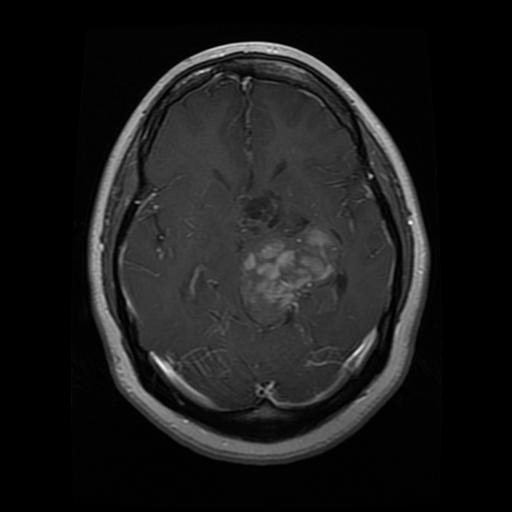

In [1]:
from PIL import Image
import numpy as np
test_img = Image.open('./explain-samples/glioma-1.jpg')
test_img

## Environment Setup
Please follow the ["Setup a new conda environment"](https://github.com/Azure/azureml-examples/tree/main/python-sdk/tutorials/automl-with-azureml#3-setup-a-new-conda-environment) instructions to get started.

In [136]:
import azureml.core

print("This notebook was created using version 1.35.0 of the Azure ML SDK.")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK.")
assert (
    azureml.core.VERSION >= "1.35"
), "Please upgrade the Azure ML SDK by running '!pip install --upgrade azureml-sdk' then restart the kernel."

## Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription or load an existing workspace.

In [19]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config('./config.json')

## Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#computes) that will be used for your AutoML model training. AutoML models for image tasks require [GPU SKUs](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu) such as the ones from the NC, NCv2, NCv3, ND, NDv2 and NCasT4 series. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [20]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "eastus-ncv3-4g"

try:
    compute_target = ws.compute_targets[cluster_name]
    print("Found existing compute target.")
except KeyError:
    print("Creating a new compute target...")
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_NC6",
        idle_seconds_before_scaledown=600,
        min_nodes=0,
        max_nodes=4,
    )
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(
    show_output=True, min_node_count=None, timeout_in_minutes=20
)

Creating a new compute target...
InProgress.
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Experiment Setup
Create an [Experiment](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#experiments) in your workspace to track your model training runs

In [21]:
from azureml.core import Experiment

experiment_name = "brain-tumor-detection-automl-explain"
experiment = Experiment(ws, name=experiment_name)

## Dataset with input Training Data

Please download the original data from the following location: https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri.

Copy all train and test images into one consolidated folder structure with the label names as subfolders. We will split the daaset into training and validation partitions later.

Folder __brain-tumor__ with subfolders: 
- glioma_tumor
- meningioma-tumor
- no-tumor
- pituitary-tumor

This is the most common data format for multiclass image classification. Each folder title corresponds to the image label for the images contained inside.

In order to use this data to create an [AzureML Tabular Dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset), we first need to convert it to the required JSONL format. Please refer to the [documentation on how to prepare datasets](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-prepare-datasets-for-automl-images).

The following script is creating two .jsonl files (one for training and one for validation) in the parent folder of the dataset. The train / validation ratio corresponds to 20% of the data going into the validation file.

In [22]:
import json
import os

src = "./brain_tumor_dataset/Training/"
train_validation_ratio = 10

# Retrieving default datastore that got automatically created when we setup a workspace
workspaceblobstore = ws.get_default_datastore().name

# Path to the training and validation files
train_annotations_file = os.path.join(src, "train_annotations.jsonl")
validation_annotations_file = os.path.join(src, "validation_annotations.jsonl")

# sample json line dictionary
json_line_sample = {
    "image_url": "AmlDatastore://"
    + workspaceblobstore
    + "/"
    + os.path.basename(os.path.dirname(src)),
    "label": "",
}

index = 0
# Scan each sub directary and generate jsonl line
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for className in os.listdir(src):
            subDir = src + className
            if not os.path.isdir(subDir):
                continue
            # Scan each sub directary
            print("Parsing " + subDir)
            for image in os.listdir(subDir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"/{className}/{image}"
                json_line["label"] = className

                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
                index += 1

Parsing ./brain_tumor_dataset/Training/glioma_tumor
Parsing ./brain_tumor_dataset/Training/meningioma_tumor
Parsing ./brain_tumor_dataset/Training/no_tumor
Parsing ./brain_tumor_dataset/Training/pituitary_tumor


### Upload the JSONL Annotations and images to Datastore
In order to use the data for training in Azure ML, we upload it to our Azure ML Workspace via a [Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores). The datastore provides a mechanism for you to upload/download data and interact with it from your remote compute targets. It is an abstraction over Azure Storage.

In [137]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir="./brain_tumor_dataset/Training/", target_path="Training")

Finally, we need to create an [AzureML Tabular Dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset) from the data we uploaded to the Datastore. We create one dataset for training and one for validation.

In [30]:
from azureml.core import Dataset
from azureml.data import DataType

# get existing training dataset
training_dataset_name = "brainTumorTrainingDataset"
# if training_dataset_name in ws.datasets:
#     training_dataset = ws.datasets.get(training_dataset_name)
#     print("Found the training dataset", training_dataset_name)
# else:
    # create training dataset
training_dataset = Dataset.Tabular.from_json_lines_files(
    path=ds.path("Training/train_annotations.jsonl"),
    set_column_types={"image_url": DataType.to_stream(ds.workspace)},
)
training_dataset = training_dataset.register(
    workspace=ws, name=training_dataset_name, create_new_version=True
)
# get existing validation dataset
validation_dataset_name = "brainTumorValidationDataset"
# if validation_dataset_name in ws.datasets:
#     validation_dataset = ws.datasets.get(validation_dataset_name)
#     print("Found the validation dataset", validation_dataset_name)
# else:
    # create validation dataset
validation_dataset = Dataset.Tabular.from_json_lines_files(
    path=ds.path("Training/validation_annotations.jsonl"),
    set_column_types={"image_url": DataType.to_stream(ds.workspace)},
)
validation_dataset = validation_dataset.register(
    workspace=ws, name=validation_dataset_name, create_new_version=True
)
print("Training dataset name: " + training_dataset.name)
print("Validation dataset name: " + validation_dataset.name)

Training dataset name: brainTumorTrainingDataset
Validation dataset name: brainTumorValidationDataset


Validation dataset is optional. If no validation dataset is specified, by default 20% of your training data will be used for validation. You can control the percentage using the `split_ratio` argument - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#model-agnostic-hyperparameters) for more details.

This is what the training dataset looks like:

In [31]:
training_dataset.to_pandas_dataframe()

image_url            label
0     workspaceblobstore/Training/glioma_tumor/gg (1...     glioma_tumor
1     workspaceblobstore/Training/glioma_tumor/gg (1...     glioma_tumor
2     workspaceblobstore/Training/glioma_tumor/gg (1...     glioma_tumor
3     workspaceblobstore/Training/glioma_tumor/gg (1...     glioma_tumor
4     workspaceblobstore/Training/glioma_tumor/gg (1...     glioma_tumor
...                                                 ...              ...
2578  workspaceblobstore/Training/pituitary_tumor/p ...  pituitary_tumor
2579  workspaceblobstore/Training/pituitary_tumor/p ...  pituitary_tumor
2580  workspaceblobstore/Training/pituitary_tumor/p ...  pituitary_tumor
2581  workspaceblobstore/Training/pituitary_tumor/p ...  pituitary_tumor
2582  workspaceblobstore/Training/pituitary_tumor/p ...  pituitary_tumor

[2583 rows x 2 columns]

## Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML Image run are specified using the `AutoMLImageConfig` - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-your-experiment-settings) for the details on the parameters that can be used and their values.

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple models. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-model-algorithms-and-hyperparameters) for the list of supported model algorithms.

### Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values for a given model to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This allows an iterative approach, as with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially, and  you need more iterations to find optimal configurations.

If you wish to use the default hyperparameter values for a given algorithm (say `resnet50`), you can specify the config for your AutoML Image runs as follows:

In [32]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, choice

image_config_resnet50 = AutoMLImageConfig(
    task=ImageTask.IMAGE_CLASSIFICATION,
    compute_target=compute_target,
    training_data=training_dataset,
    validation_data=validation_dataset,
    hyperparameter_sampling=GridParameterSampling({"model_name": choice("resnet50")}),
    iterations=1,
)

In [138]:
automl_image_run = experiment.submit(image_config_resnet50)

In [134]:
automl_image_run.wait_for_completion(wait_post_processing=True)

## Register the model from the run

In [35]:
# Register the model from the best run
from azureml.train.automl.run import AutoMLRun
# automl_image_run = AutoMLRun(experiment=experiment, run_id="AutoML_dea7cd4a-b58e-42a7-88e9-197fb984520a")
best_child_run = automl_image_run.get_best_child()
model_name = 'brain_tumor_detection'
model = best_child_run.register_model(
    model_name=model_name, model_path="outputs/model.pt"
)


In [139]:
from azureml.core import Model
model_to_deploy = Model(name="brain_tumor_detection", workspace=ws)
model_to_deploy

## Inference Configuration

In [ ]:
from azureml.core.conda_dependencies import CondaDependencies

environment=best_child_run.get_environment()
environment.python.conda_dependencies.add_conda_package("captum==0.5.0")
environment.python.conda_dependencies.add_pip_package("colorcet")
environment


In [53]:
env = environment.clone("AutoML-DNN-Vision-GPU-Explain")

In [ ]:
from azureml.core import Environment
env.register(ws)
env = Environment.get(workspace=ws, name='AutoML-DNN-Vision-GPU-Explain')
env

In [55]:
from azureml.core.model import InferenceConfig
from azureml.core import Environment

inference_config = InferenceConfig(entry_script="scoring_with_explain.py", source_directory = "src", environment=env)

## Inference Cluster

In [77]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "aks-tumor-xai"
# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing compute target")
except ComputeTargetException:
    print("Creating a new compute target...")
    # Provision AKS cluster with a CPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="Standard_F8s")
    # Create the cluster
    aks_target = ComputeTarget.create(
        workspace=ws, name=aks_name, provisioning_configuration=prov_config
    )
    aks_target.wait_for_completion(show_output=True)

Found existing compute target


## Create Deployment

In [ ]:
# Deploy the model from the best run as an AKS web service
from azureml.core.webservice import AksWebservice
from azureml.core.model import Model

aks_config = AksWebservice.deploy_configuration(
    cpu_cores=1, memory_gb=8, scoring_timeout_ms=300000)

aks_service = Model.deploy(
    ws,
    models=[model_to_deploy],
    inference_config=inference_config,
    deployment_config=aks_config,
    deployment_target=aks_target,
    name="automl-brain-tumor-xai",
    overwrite=True,
)
aks_service.wait_for_deployment(show_output=True)
print(aks_service.state)

### Perform Inference with Explanations

In [80]:
from io import BytesIO
import base64


def img_to_base64(img_path):
    """Load and convert pillow image to base64-encoded image"""

    img = Image.open(img_path)
    imgio = BytesIO()
    img.save(imgio, img.format)
    img_str = base64.b64encode(imgio.getvalue())
    return img_str.decode('utf-8')


def create_json_load(image_list_path, explanation_method="gradcam"):
    img_strs = []
    for image_path in image_list_path:
        img_strs.append(img_to_base64(image_path))
    json_data = json.dumps({'explanation_method': explanation_method, 'data':img_strs})

    return json_data


In [81]:
from azureml.core.webservice import AksWebservice
import requests
from PIL import Image
from utils import show_mask, show_mask_on_image, cut_image_with_mask
from matplotlib import pyplot as plt
import colorcet as cc
import os
import numpy as np
import json
import base64


# URL for the web service

aks_service = AksWebservice(workspace=ws, name="automl-brain-tumor-xai")
scoring_uri = aks_service.scoring_uri

# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()

sample_image = "./explain-samples/glioma-1.jpg"

# Set the content type
headers = {"Content-Type": "application/json"}

# If authentication is enabled, set the authorization header
headers["Authorization"] = f"Bearer {key}"

# Make the request and display the response
json_data = create_json_load(["./explain-samples/glioma-1.jpg"], explanation_method="gradcam")

resp = requests.post(scoring_uri, json_data, headers=headers)

In [82]:
resp.json()

{'pred_label_idx': [0],
 'prediction_score': [0.9999953508377075],
 'attributions': [[[[-0.15193575620651245],
    [-0.15219232439994812],
    [-0.15240123867988586],
    [-0.15255552530288696],
    [-0.1526482105255127],
    [-0.15267233550548553],
    [-0.15262092649936676],
    [-0.15248693525791168],
    [-0.15226352214813232],
    [-0.15194359421730042],
    [-0.15152022242546082],
    [-0.1509864777326584],
    [-0.15033528208732605],
    [-0.14955976605415344],
    [-0.14865291118621826],
    [-0.1476077288389206],
    [-0.1464293748140335],
    [-0.1451871693134308],
    [-0.1438954621553421],
    [-0.14255693554878235],
    [-0.14117440581321716],
    [-0.1397504061460495],
    [-0.138287752866745],
    [-0.13678906857967377],
    [-0.1352570354938507],
    [-0.13369439542293549],
    [-0.1321038156747818],
    [-0.13048799335956573],
    [-0.12884964048862457],
    [-0.12719139456748962],
    [-0.12551599740982056],
    [-0.12382613122463226],
    [-0.12212447822093964],
    

## Visualize Explanations - GradCam

Predicting for ./explain-samples\glioma-1.jpg


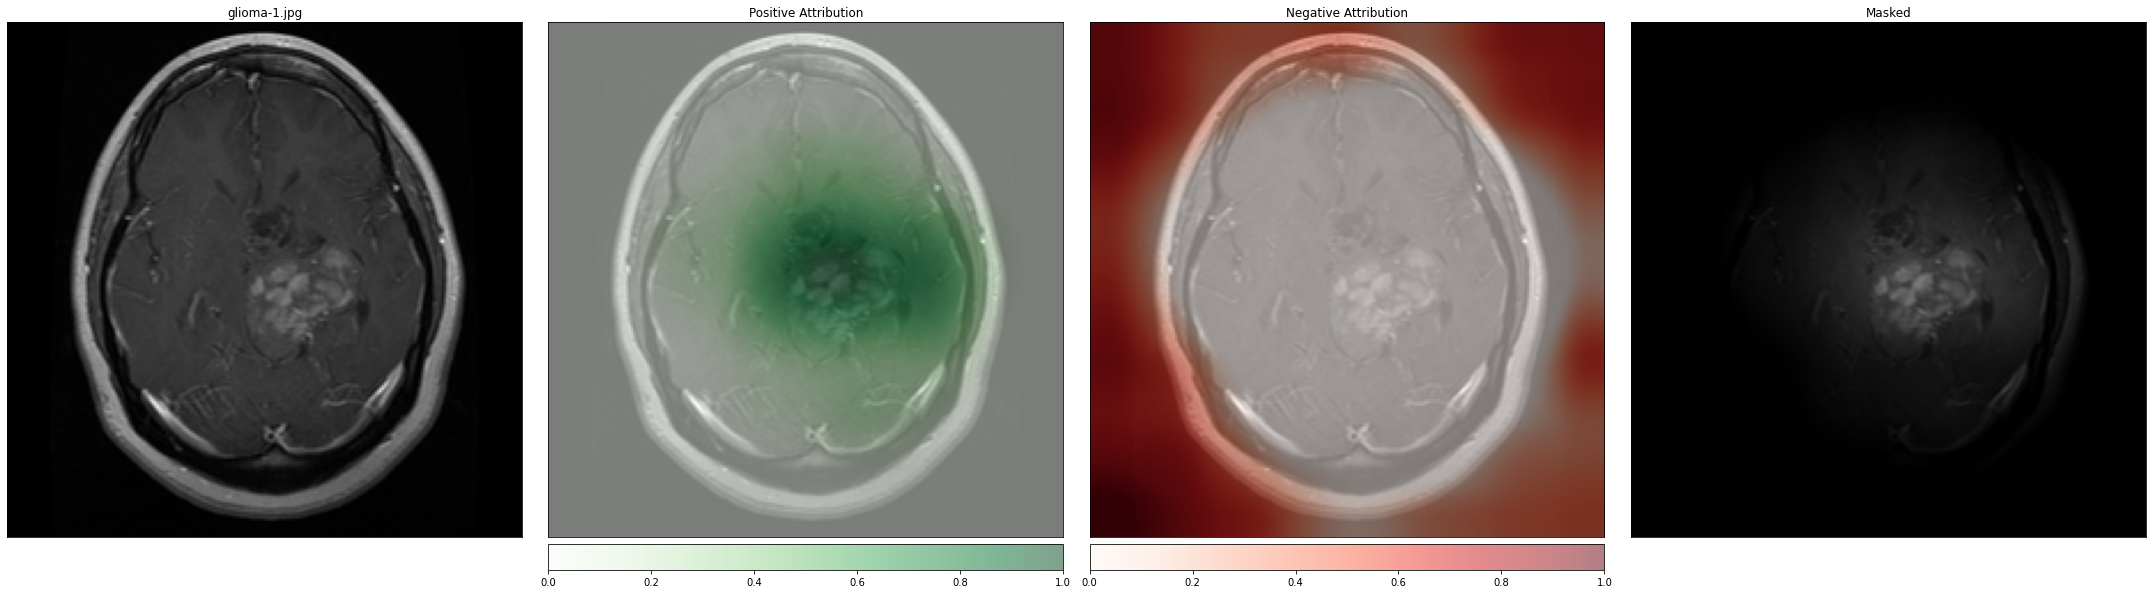

Predicting for ./explain-samples\meningioma_tumor_6.jpg


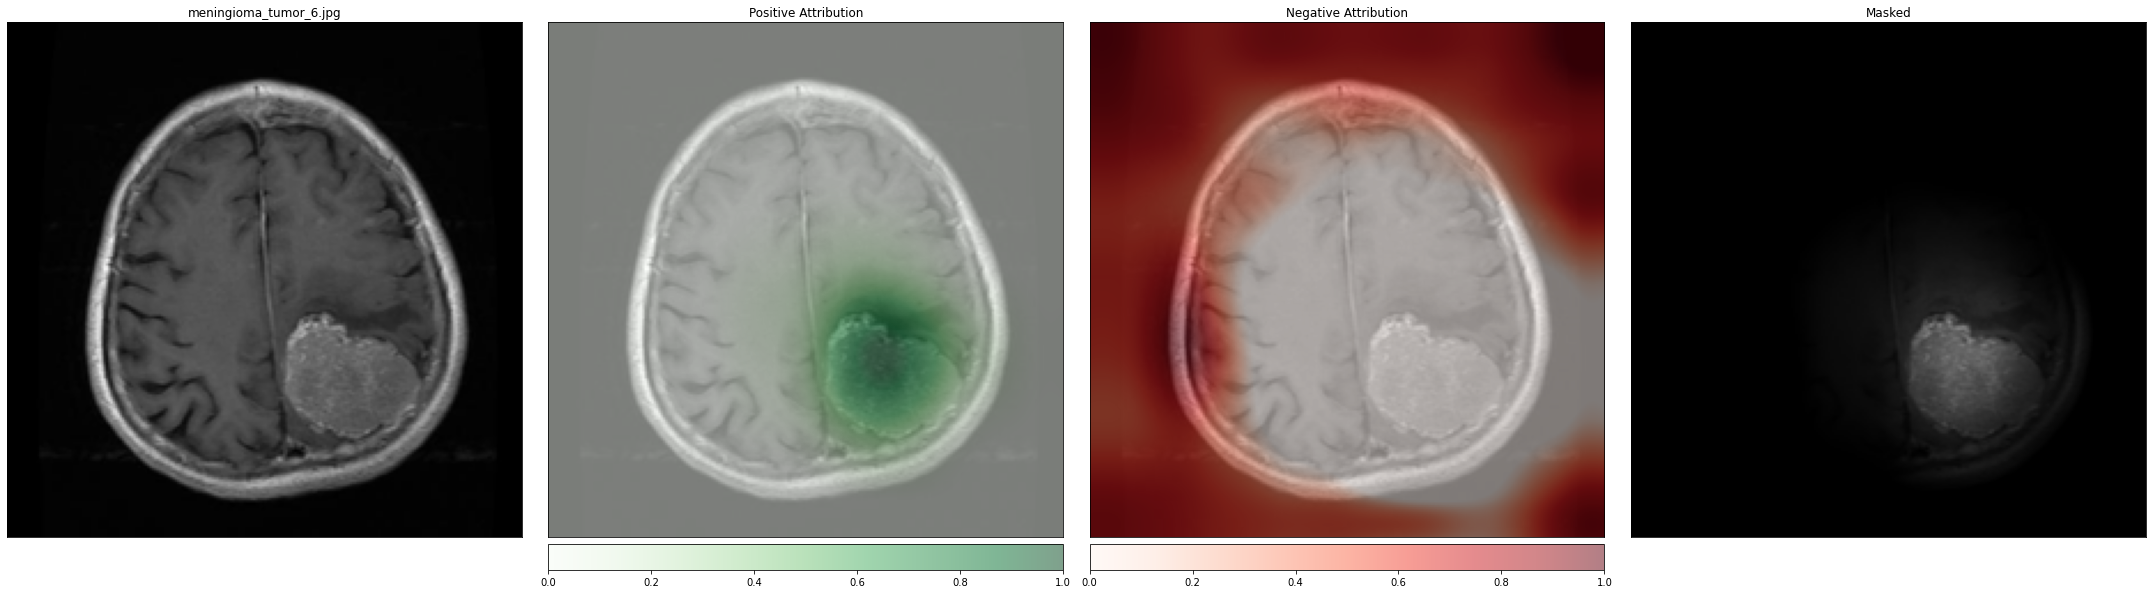

In [129]:
from captum.attr import visualization as viz
# from preprocess_img import preprocess
from azureml.automl.dnn.vision.classification.common.transforms import _get_common_valid_transforms

explain_folder = './explain-samples'

img_ext =  ('png', 'jpg',  'tiff', 'bmp', 'gif')
images = [file for file in os.listdir(explain_folder) if file.lower().endswith(img_ext)]

for image_file in images:
    test_img_np = preprocess(os.path.join(explain_folder, image_file))
    json_data = create_json_load([os.path.join(explain_folder, image_file)], explanation_method="gradcam")
    resp = requests.post(scoring_uri, json_data, headers=headers)
    attributions = np.array(resp.json()['attributions'][0])
    # visualize results
    _ = viz.visualize_image_attr_multiple(attributions,
                                          test_img_np,
                                          ["original_image","blended_heat_map","blended_heat_map", "masked_image"],
                                          ["all","positive","negative", "positive"],
                                          show_colorbar=True,
                                          titles=[image_file, "Positive Attribution", "Negative Attribution", "Masked"],
                                          fig_size=(30, 10))

## Integrated Gradients

Predicting for ./explain-samples\glioma-1.jpg


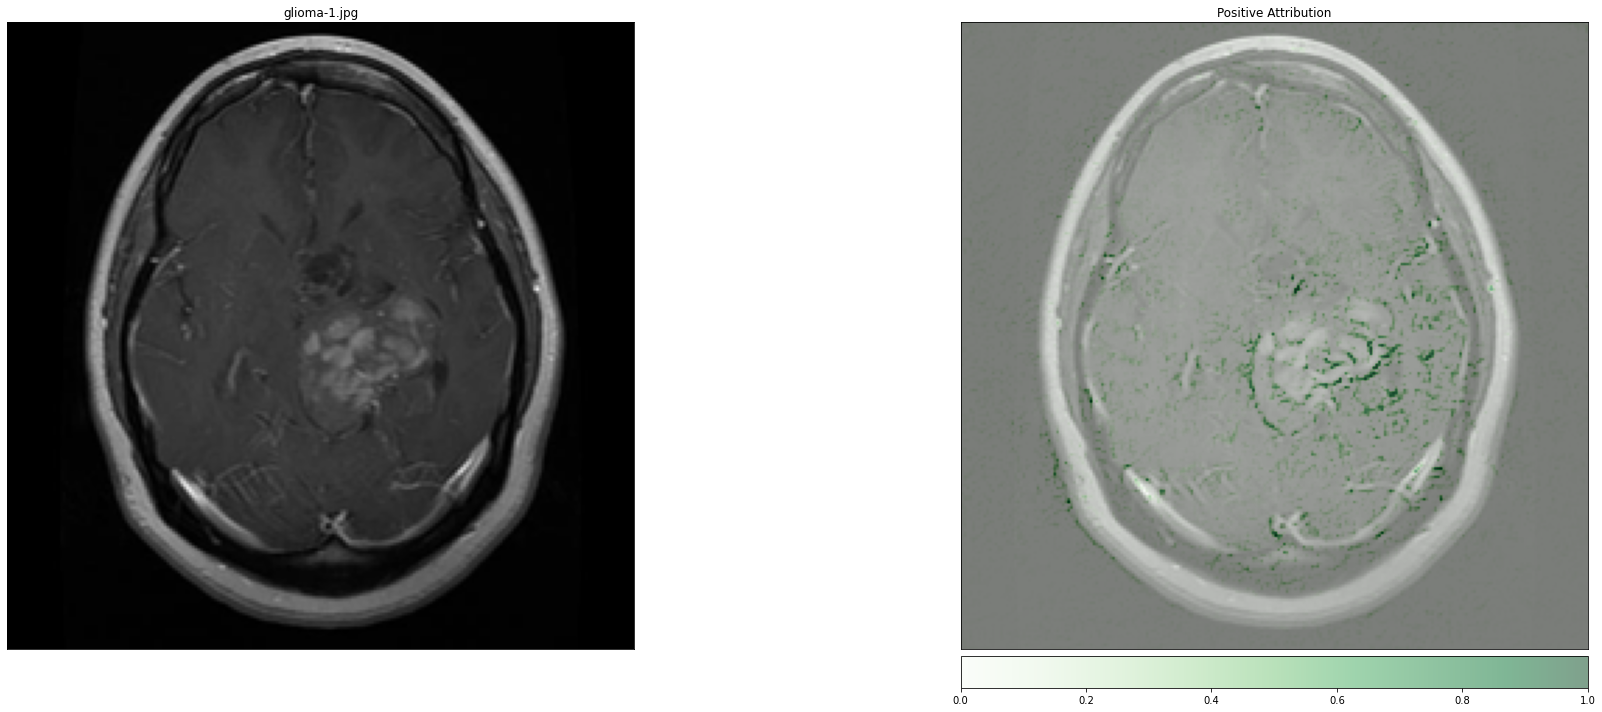

Predicting for ./explain-samples\meningioma_tumor_6.jpg


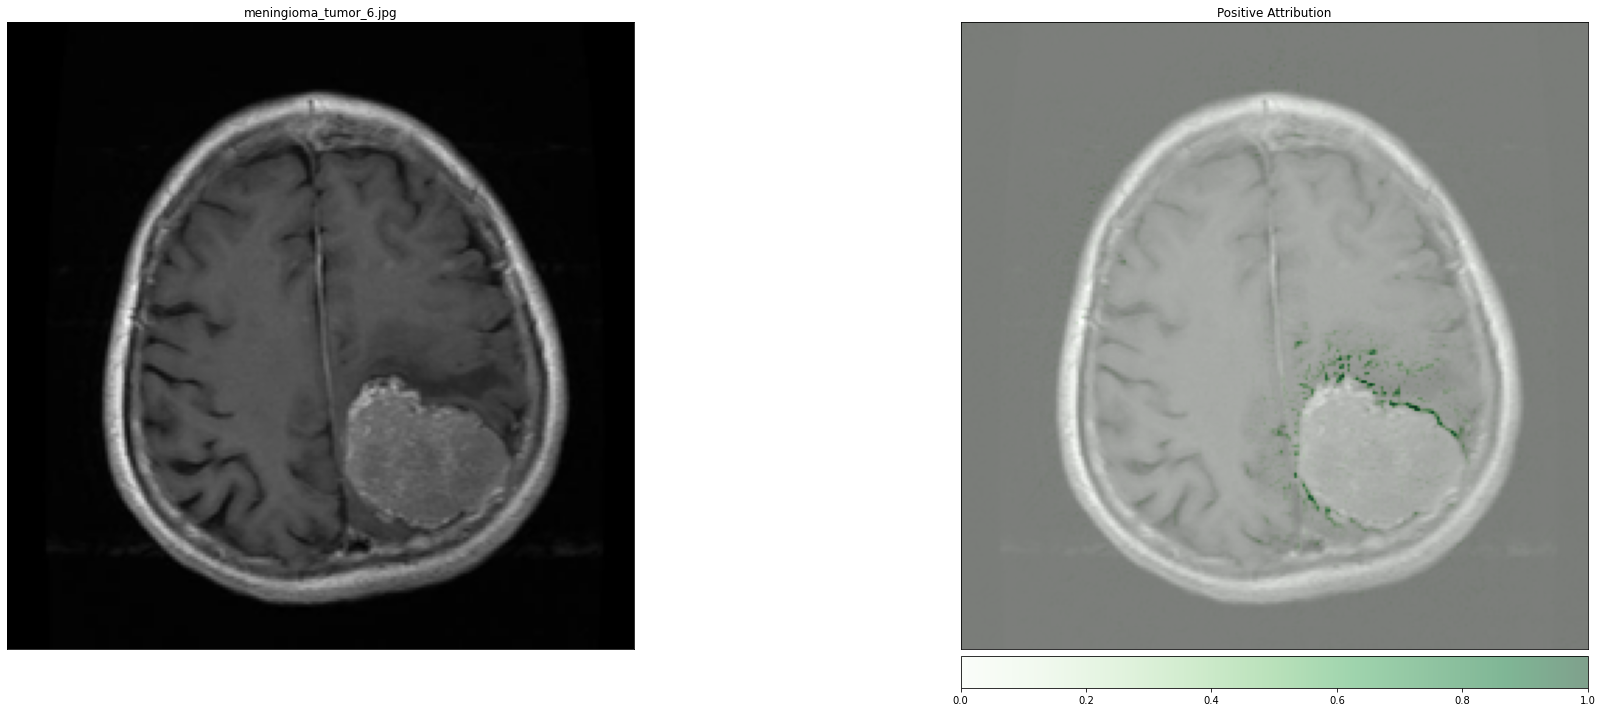

In [131]:
from captum.attr import visualization as viz

explain_folder = './explain-samples'

img_ext =  ('png', 'jpg',  'tiff', 'bmp', 'gif')
images = [file for file in os.listdir(explain_folder) if file.lower().endswith(img_ext)]

for image_file in images:
    test_img_np = preprocess(os.path.join(explain_folder, image_file))
    json_data = create_json_load([os.path.join(explain_folder, image_file)], explanation_method="integrated-gradients")
    resp = requests.post(scoring_uri, json_data, headers=headers)
    attributions = np.array(resp.json()['attributions'][0])
    # visualize results
    _ = viz.visualize_image_attr_multiple(attributions,
                                          test_img_np,
                                          ["original_image","blended_heat_map"],
                                          ["all","positive"],
                                          show_colorbar=True,
                                          titles=[image_file, "Positive Attribution"],
                                          fig_size=(30, 10))

## Guided Backpropagation

Predicting for ./explain-samples\glioma-1.jpg


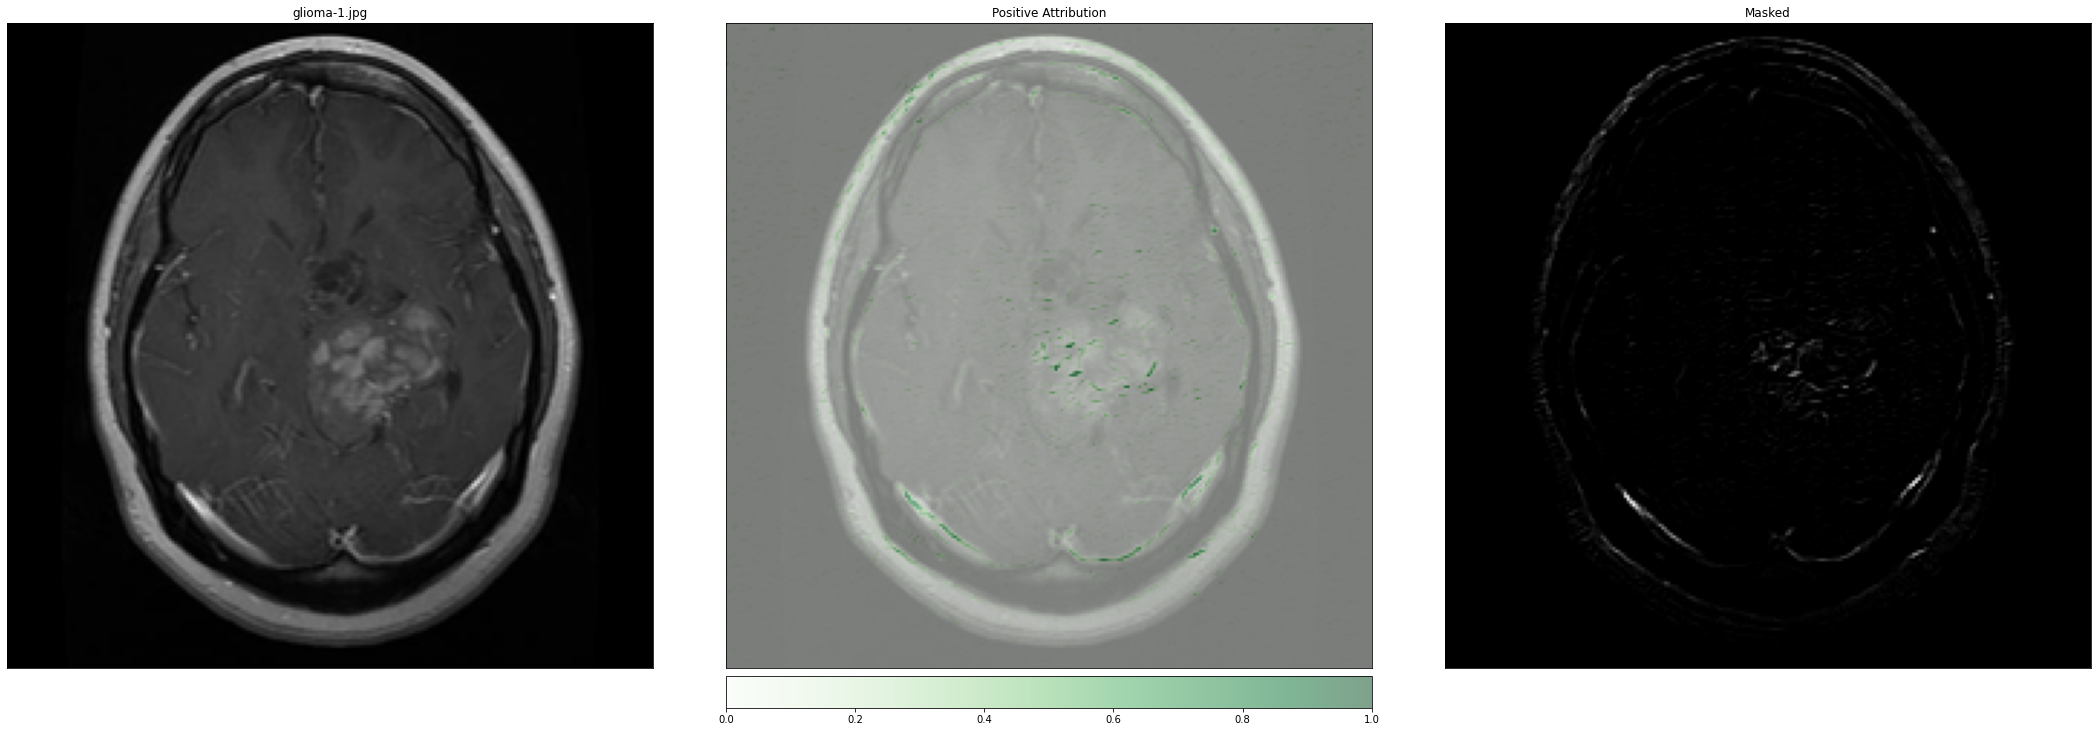

Predicting for ./explain-samples\meningioma_tumor_6.jpg


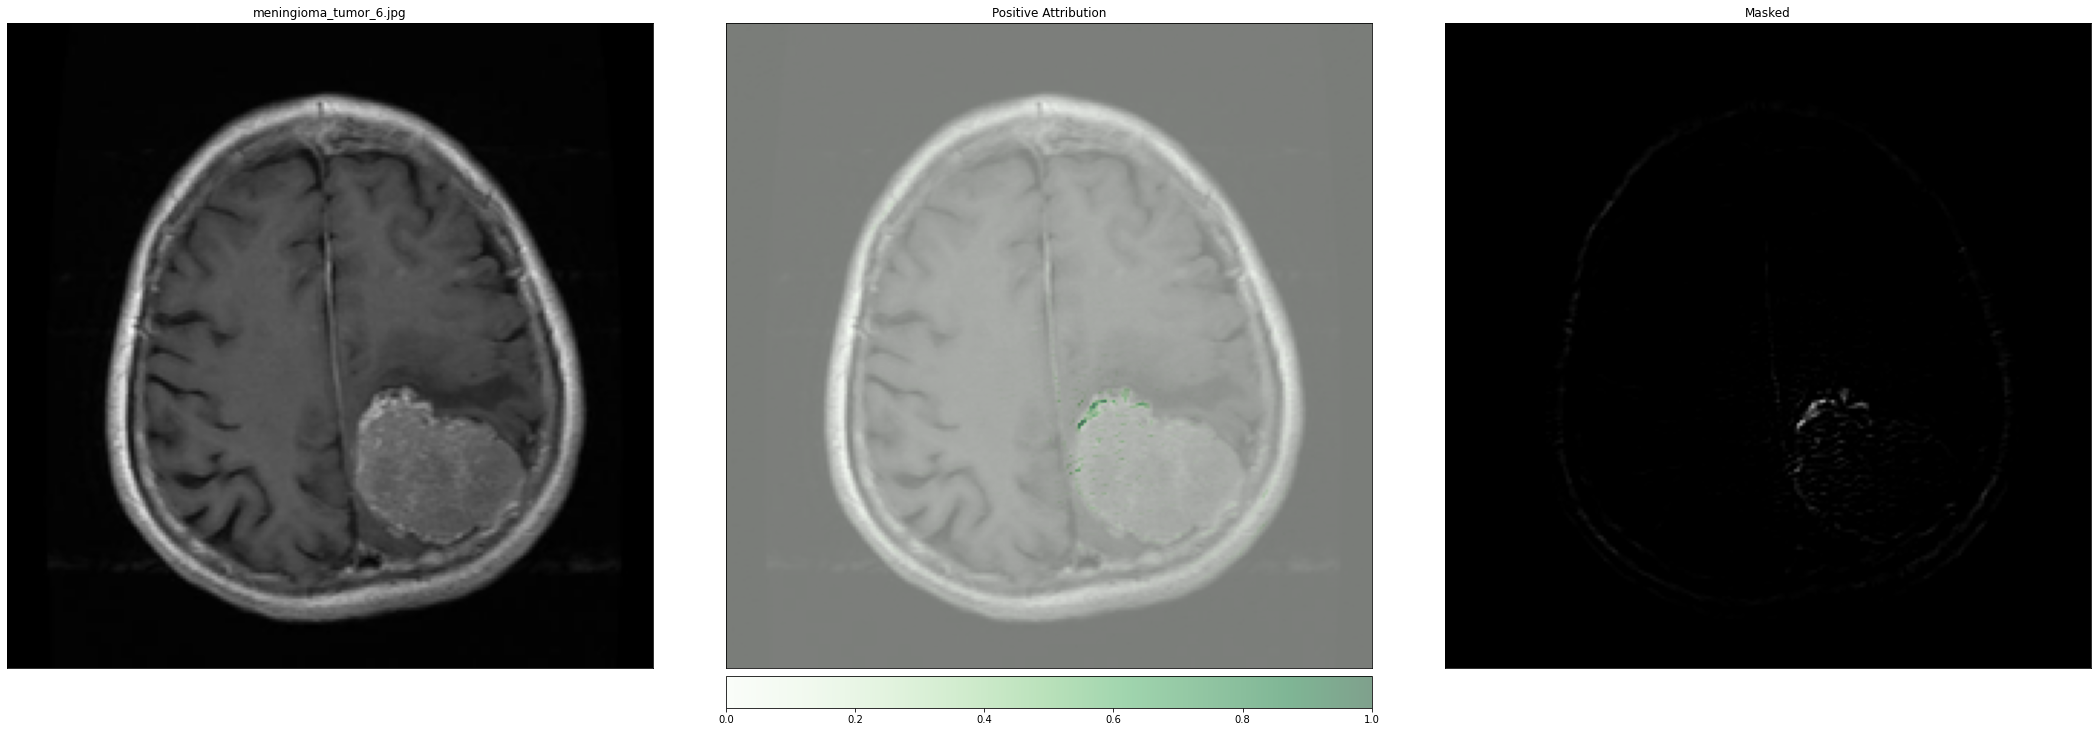

In [132]:
from captum.attr import visualization as viz

explain_folder = './explain-samples'

img_ext =  ('png', 'jpg',  'tiff', 'bmp', 'gif')
images = [file for file in os.listdir(explain_folder) if file.lower().endswith(img_ext)]

for image_file in images:
    test_img_np = preprocess(os.path.join(explain_folder, image_file))
    json_data = create_json_load([os.path.join(explain_folder, image_file)], explanation_method="guided-backpropagation")
    scoring_uri = aks_service.scoring_uri
    headers = {"Content-Type": "application/json"}
    headers["Authorization"] = f"Bearer {key}"
    resp = requests.post(scoring_uri, json_data, headers=headers)
    attributions = np.array(resp.json()['attributions'][0])
    # visualize results
    _ = viz.visualize_image_attr_multiple(attributions,
                                          test_img_np,
                                          ["original_image","blended_heat_map","masked_image"],
                                          ["all","positive","positive"],
                                          show_colorbar=True,
                                          titles=[image_file, "Positive Attribution", "Masked"],
                                          fig_size=(30, 10))

## XRAI explanation of Tumors

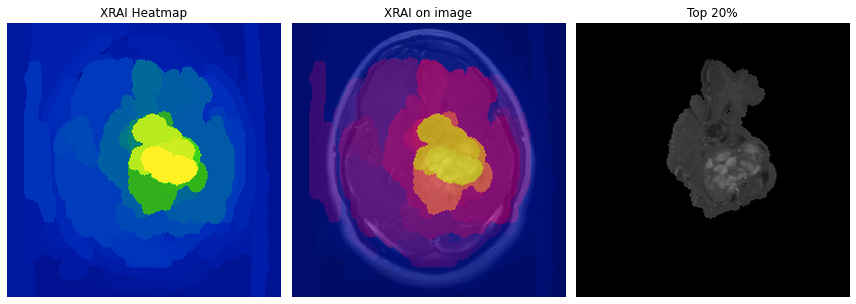

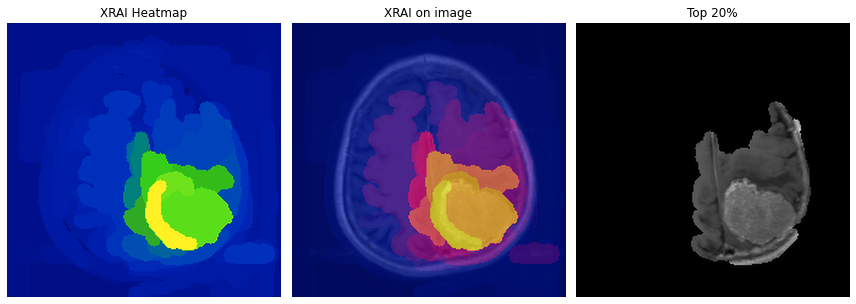

In [135]:
from captum.attr import visualization as viz

explain_folder = './explain-samples'

img_ext =  ('png', 'jpg',  'tiff', 'bmp', 'gif')
images = [file for file in os.listdir(explain_folder) if file.lower().endswith(img_ext)]

for image_file in images:
    json_data = create_json_load([os.path.join(explain_folder, image_file)], explanation_method="xrai")
    resp = requests.post(scoring_uri, json_data, headers=headers)
    attributions = np.array(resp.json()['attributions'][0])
    # visualize results
    figure, axes = plt.subplots(1, 3, figsize=(12, 12), tight_layout=True)
    show_mask(attributions, title='XRAI Heatmap', cmap=cc.cm.bgy, norm=True, axis=axes[0])
    show_mask_on_image(image_path=os.path.join(explain_folder, image_file), mask=attributions, norm=True, title='XRAI on image', axis=axes[1])
    cut_image_with_mask(image_path=os.path.join(explain_folder, image_file), mask=attributions, title='Top 20%', percentile=80, axis=axes[2])